In [1]:
# Start ferret
import pyferret
import numpy as np
pyferret.start(quiet=True)


True

In [2]:
# Load the data set and store as a Python variable
# Python dictionaries are a type of variable that
# stores the data along with its metadata.
(error_value, error_message) = pyferret.run('use /home/jovyan/data/1_mesh_mask.nc')
glamt_dict = pyferret.getdata('glamt',False)
gphit_dict = pyferret.getdata('gphit',False)

# Also, use some existing masking in Ferret to zero
# out any area points.
(error_value, error_message) = pyferret.run('let area = e1t[d=1]*e2t[d=1]*tmask[d=1,k=1]')
area_masked_dict = pyferret.getdata('area',False)

(error_value, error_message) = pyferret.run('let area = e1t[d=1]*e2t[d=1]')
area_dict = pyferret.getdata('area',False)

# The "keys" are the names of the entries in the
# dictionary - its pieces.
glamt_dict.keys()

dict_keys(['title', 'data', 'missing_value', 'data_unit', 'axis_types', 'axis_names', 'axis_units', 'axis_coords'])

In [3]:
# Get data directly from the dictionary object (which
# includes metadata) and squeeze out unnecessary
# index places.
glamt = np.squeeze(glamt_dict['data'])
gphit = np.squeeze(gphit_dict['data'])
area = np.squeeze(area_dict['data'])
area_masked = np.squeeze(area_masked_dict['data'])

# Get the sizes of the arrays. _m -> max
im,jm = np.shape(glamt)

np.shape(glamt_dict['data'])

(1784, 1719, 1, 1, 1, 1)

In [11]:
# Need to rotate the array to plot North upward
# Experiments with this suggest that it doesn't
# work as I initially expected.
# Need to do more experiments.
#glamt = np.reshape(glamt,(jm,-1), order='C')
#gphit = np.reshape(gphit,(jm,-1), order='C')

# Instead, here we need to specify the other grid
# parameters. 
# Depth is always 1 for this dataset.
km = 1  
# Start at 731 (1st snap after 10 years of spin up, 1958)
# End at 4526 (endpoint of data set, note +1 for python)
lstart = 731
#lend = 735
lend = 4526
lmn = lend - lstart + 1

# And now specify the amount of cutting down ( _bm ->
# blockmean) and the size of the output array.  Grid
# can be selectively cut in x(i) or y(j) axis.  For
# example, 20 on a 1/20 deg. grid -> 1 degree output.
ibm = 100
jbm = 100

# The new max values, _mn, are calculated here.  Any partial
# boxes on the far Northern/Eastern side will be ignored.
imn = int(im/ibm)
jmn = int(jm/jbm)

# Create output arrays
glamt_new = np.zeros((imn,jmn,km,1,1,1))
gphit_new = np.zeros((imn,jmn,km,1,1,1))
ssh_new = np.zeros((imn,jmn,km,lmn,1,1))

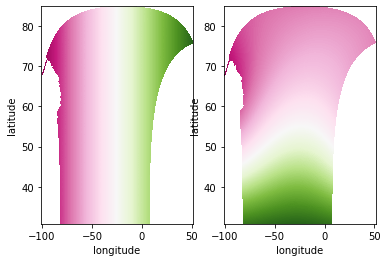

In [12]:
# Make a plot to verify that data have been loaded
# Using pcolormesh is good because it explicitly
# requires the pixel locations rather than implicit
# pixel locations with an image plotting tool.
import matplotlib.pyplot as plt
cmap = plt.get_cmap('PiYG')
# Use tuple unpacking to list the axes.
# See: https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(ncols=2)
axs[0].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],glamt[1:im-2,1:jm-2], cmap=cmap)
#axs[1].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2], cmap=cmap)
axs[1].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],area[1:im-2,1:jm-2], cmap=cmap)

for ax in axs:
    ax.set(xlabel='longitude',ylabel='latitude')

plt.show()

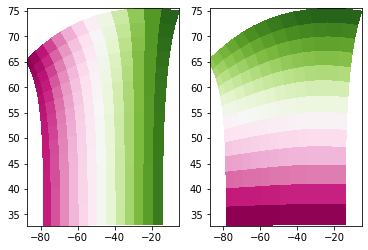

In [13]:
# Multiply arrays to be averaged by weight (area in this case)
glamt_w = np.multiply(glamt,area)
gphit_w = np.multiply(gphit,area)

# Create cut down versions of the lon, lat grids
for ii in range(1,imn):
    
    # Comments for index logic.  Same logic
    # for j direction.
    # For ii = 1, we want exactly 1.
    # For ii = imn, we want start of the last block,
    #  which is +1 of the end of the previous block.
    # Finally, note all subtract 1 because Python
    # index counting starts at 0.
    istart = 1+ibm*(ii-1) - 1
    
    # For ii = 1, we want the end of the first block
    # For ii = imn, we want the end of the last block
    iend = ibm*ii - 1
    
    for jj in range(1,jmn):

        jstart = 1+jbm*(jj-1) - 1 
        jend = jbm*jj - 1
        
        # We use area here (and not the masked area as below)
        # because glamt and gphit are coordinates and so they
        # have valid data over land as well as over the ocean.
        glamt_new[ii,jj,0,0,0,0] = np.sum(
            glamt_w[istart:iend,jstart:jend])/np.sum(area[istart:iend,jstart:jend])
        gphit_new[ii,jj,0,0,0,0] = np.sum(
            gphit_w[istart:iend,jstart:jend])/np.sum(area[istart:iend,jstart:jend])
        
# Plot to see if the results make sense
glamt_new_plt = np.squeeze(glamt_new)
gphit_new_plt = np.squeeze(gphit_new)
fig, axs = plt.subplots(ncols=2)
axs[0].pcolormesh(glamt_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2],glamt_new_plt[1:imn-2,1:jmn-2], cmap=cmap)
axs[1].pcolormesh(glamt_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2], cmap=cmap)

In [14]:
# Clear some extraneous variables before we do the heavy crunching.
del glamt_w
del gphit_w


In [15]:
# Load SSH data
(error_value, error_message) = pyferret.run('use /home/jovyan/data/V20_1948_2009_SSH.nc')

# Ideally, here we load the time step information
# and allow the code to automatically pull this
# from the data.  However, I'm not doing that here
# because I cannot load the whole file to memory
# and I don't want to do any text processing from
# the Ferret show data command.

In [17]:
# Now all we need to do is iterate over the time index,
# passing a new string object to ferret to get that field
# and then apply the blockmean operation on the field
# and store the output.  Note that range includes the
# first value but goes up to, but not to, the last value.
for ll in range(lstart, lend+1):
    # Test loop ranges
    print(str(ll))
    
    # Load data from this time step
    ferret_var = 'sossheig[d=2,l='+str(ll)+']'
    ssh_dict = pyferret.getdata(ferret_var,False)
    ssh = np.squeeze(ssh_dict['data'])
    ssh_w = np.multiply(ssh,area_masked)
    
    # Find number of missing values and post warning if present
    missing = np.abs(ssh - ssh_dict['missing_value']) < 1.0E-5
    if np.sum(missing) > 0:
        print('Warning! Missing values dectected!')
    
    del ssh
    
    # Cut data down and save to array.  See
    # how glamt and gphit were cut down for
    # comments on the logic.
    for ii in range(1,imn):
        
        istart = 1+ibm*(ii-1) - 1
        iend = ibm*ii - 1
        
        for jj in range(1,jmn):
            
            jstart = 1+jbm*(jj-1) - 1 
            jend = jbm*jj - 1
        
            # Need to check for land (empty) data points
            # and ensure that fill values on land do not
            # "bleed" into the averages near the coast.
            denominator = np.sum(area_masked[istart:iend,jstart:jend])
            if denominator == 0:
                ssh_new[ii,jj,0,ll-lstart,0,0] = 0
            else:
                ssh_new[ii,jj,0,ll-lstart,0,0] = np.sum(
                ssh_w[istart:iend,jstart:jend])/denominator

731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980


2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623


4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264


In [ ]:
# Assign metadata keys to variables to save.ssh_dict.keys()
# We need the following keys (see output of first cell)
# See example code at: https://ferret.pmel.noaa.gov/Ferret/documentation/pyferret/example-sessions-python
# And more detailed docs for the metadata at:
# https://ferret.pmel.noaa.gov/Ferret/documentation/pyferret/data-dictionaries
# dict_keys([
#   'title', # long title
#   'data', # assign ssh_new
#   'missing_value', # array([9.96920997e+36]) = no change, but need to reapply after tmask.
#   'data_unit',  # 'm' - no change
#   'axis_types', # (6,6,7,4,7,7) = (abstract,abstract,empty,time,empty,empty) = no change
#   'axis_names', # ('X','Y','','TIME','','') = no change
#   'axis_units', # ('', '', '', 'CALTYPE_NOLEAP', '', '') = no change
#   'axis_coords' # needs to go (array([1:imn]),array([1:jmn]))
# ])
ssh_dict['missing_value']


In [ ]:
ssh_dict['axis_coords'][1]

In [ ]:
# Make a plot of the SSH map
fig, ax = plt.subplots()
ax.pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],ssh[1:im-2,1:jm-2], cmap=cmap)

In [ ]:
ssh_new
